In [51]:
from typing import * 

import numpy as np
import matplotlib.pyplot as plt
import qiskit.quantum_info 
from scipy.stats import entropy

from src.Qubo import Qubo
from src.Chain import Chain
from src.Grid import Grid
from src.CP_VQA.Qulacs_CP_VQA import Qulacs_CP_VQA

In [52]:
# Function to compute fidelity between two states
def generate_haar_random_states(num_states, N_qubits):
    return [qiskit.quantum_info.random_statevector(2**N_qubits).data for _ in range(num_states)]

def calculate_fidelity_distribution(states1: List[np.ndarray[complex]], 
                                    states2: List[np.ndarray[complex]]):
    states1 = np.array(states1)
    states2 = np.array(states2)

    # Compute the dot product in a vectorized way
    dot_products = np.dot(states1, states2.T.conj())

    # Calculate the fidelity for each combination and flatten the array
    fidelities = np.abs(dot_products)**2
    return fidelities.flatten()

def plot_normalized_histogram(fidelities: np.ndarray, 
                              N_bins: int, 
                              color: str):
    frequencies, x_lims = np.histogram(fidelities, bins=N_bins, density=True)
    normalized_frequencies = frequencies / np.sum(frequencies)
    w = x_lims[1]-x_lims[0]
    for f,x in zip(normalized_frequencies,x_lims):
        plt.bar(x, f, w, 0, color=color, alpha=0.5)    

def calculate_kl_divergence(dist1, dist2):
    return entropy(dist1, dist2)

In [53]:
qubits, layers = 4, 10
seed = 1
np.random.seed(seed)
alpha = 0.5
w_nnn = False
init_strat = np.array([1 if i%2 == 1 else 0 for i in range(qubits)])
my_indices = [(i, i+1) for i in range(qubits-1)]
# Defining topology
my_chain = Chain(N_qubits=qubits)
my_chain.set_initialization_strategy(strategy=init_strat)

# Deciding between grid and 1d chain topology
my_topology = my_chain
Q = np.triu(np.random.uniform(-1,1,(qubits,qubits)))
qubo = Qubo(Q=Q, offset=np.random.uniform(-1,1))
ansatz = Qulacs_CP_VQA(N_qubits=qubits, cardinality=qubits//2, 
                       layers=layers, qubo=qubo, 
                       with_next_nearest_neighbors=w_nnn,
                       topology=my_topology, use_parametric_circuit_opt=True)

In [54]:
N_samples = 2000
sampled_states = []
for sample in range(N_samples):
    n_angles = layers * len(my_topology.get_NNN_indices()) if w_nnn else layers * len(my_topology.get_NN_indices())
    angles = np.random.uniform(-np.pi,np.pi, layers * len(my_topology.get_NN_indices()))
    psi = ansatz.get_statevector(angles=angles)
    sampled_states.append(psi)

KL Divergence: 1.5903957846904206


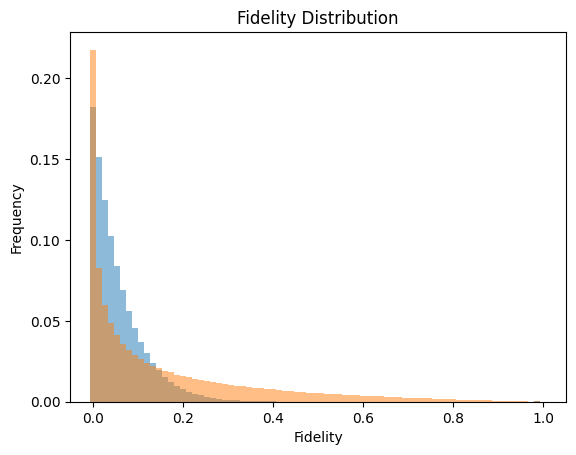

In [55]:
# Parameters
num_haar_states = N_samples  # Adjust as needed
num_pqc_states = N_samples   # Adjust as needed
dim = qubits                 # Adjust for the dimension of your quantum system

# Generate states
haar_states = generate_haar_random_states(num_haar_states, dim)
pqc_states = sampled_states  # Replace this with your PQC states

# Calculate fidelity distributions
fidelities_haar = calculate_fidelity_distribution(haar_states, haar_states)
fidelities_pqc = calculate_fidelity_distribution(pqc_states, pqc_states)

# Plot histograms
plot_normalized_histogram(fidelities=fidelities_haar,N_bins=75,color='tab:blue')
plot_normalized_histogram(fidelities=fidelities_pqc, N_bins=75,color='tab:orange')
plt.xlim(-0.05,1.05)
plt.xlabel('Fidelity')
plt.ylabel('Frequency')
plt.title('Fidelity Distribution')
# Calculate and print KL divergence
kl_div = calculate_kl_divergence(fidelities_haar, fidelities_pqc)
print(f"KL Divergence: {kl_div}")
